Goal of this project was to implement ML algorithm "from scratch". Model should be able to perform multilabel classification tasks and must be compatible with Sklearn Pipeline.

I went with softmax regression algorithm, because it can use gradient descent, and can be modified a lot.

# Data load and additional functions 

For our initial testing we're using well known Iris dataset (we want our model to be able to perform multilabel classification)

In [38]:
import numpy as np
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [39]:
X = iris["data"]  # 
y = iris["target"]  # 

In [40]:
X.shape

(150, 4)

In [41]:
# This additional functions aren't used in this model (they were made for testing purposes)

# Simple function to make train_dev_test split in a single run
def tr_dev_test_split(X, y, train_size=0.6, dev_size=0.2, test_size=0.2):
  assert len(X) == len(y)
  total_size = len(X)
  train_size = round(total_size * train_size)
  dev_size = round(total_size * dev_size)
  test_size = round(total_size * test_size)

  indices = np.random.permutation(total_size)
  X_train = X[indices[:train_size]]
  y_train = y[indices[:train_size]]
  X_dev = X[indices[train_size : train_size + dev_size]]
  y_dev = y[indices[train_size : train_size + dev_size]]
  X_test = X[indices[train_size + dev_size:]]
  y_test = y[indices[train_size + dev_size:]]
  return X_train, y_train, X_dev, y_dev, X_test, y_test

# One hot encoder version
def one_hot_classes(y):
  classes = np.unique(y)
  m = len(y)
  one_hot_matr = np.zeros((m, len(classes)))
  one_hot_matr[np.arange(m), y] = 1
  return one_hot_matr

# Simple standart scaler
class StdScaler():
  def fit_transform(self, X):
    return (X - X.mean(axis=0)) / X.std(axis=0)

# Softmax regressor class

Implementation of Mini-batch Gradient Descent for Softmax Regression
(Design compatible with Scikit-Learn pipelines).

Equation for the gradients:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

In [42]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from scipy.sparse import csr_matrix

class SoftmaxRegressor(BaseEstimator, ClassifierMixin):
  """ 
  Linear classification algorithm based on softmax function. 
  Uses mini-batch gradient descent with cross-entropy loss function
  Params: 
  batch_size: float {[0-0.5],1}, percent of data in learning batch 
  eta: float, learning rate
  n_epochs: int, amount of epochs to learn
  alpha: float, param of l2 regularization. If alpha=0 no regularization applied
  train_scedule: bool, if True, learning rate will be gradually decresing.
  eta1: float, learning rate schedule param. Used if train_schedue=True
  warm_start: bool, if True, model keeps params (theta) of previous fit.
  verbose: int, if == 1 -> prints loss function 10 times
  """
  def __init__(self, batch_size=0.2, n_epochs=500, eta=0.1, alpha=0, train_schedule=False, eta1=50, warm_start=False, verbose=0):
    # Initialising model hyperparameters
    self.batch_frac = batch_size
    self.n_epochs = n_epochs
    self.eta = eta
    self.alpha = alpha
    self.train_schedule = train_schedule
    self.eta1 = eta1
    self.warm_start = warm_start
    self.verbose = verbose
    self.first_fit = True

  def fit(self, X,y):
    """
    Fit the model according to the given training data.
    Params:
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and  
        n_features is the number of features.  
    y : array-like of shape (n_samples,), Target vector relative to X. 
    """

    # Batch size preparation
    if self.batch_frac == 1:
      self.batch_size = X.shape[0]
    elif 0 < self.batch_frac <= 0.5:
      self.batch_size = int(X.shape[0] * self.batch_frac)
    else:
      raise ValueError("Wrong batch size")

    X = self._add_intercept(X)               # add bias/intercept
    y = self._one_hot_target(y)              # one hot classes
    # Initialise params/weights (theta)
    if (self.warm_start == False) or (self.first_fit == True):
      self.theta_matr = np.random.rand(X.shape[1],y.shape[1]) 
      self.first_fit = False 

    for epoch in range(self.n_epochs):
      # Shuffling data for batches
      shuffled_indices = np.random.permutation(X.shape[0])
      X_shuffled = X[shuffled_indices]
      y_shuffled = y[shuffled_indices]

      # Train schedule
      if self.train_schedule:
        self.eta = self._train_schedule(epoch)

      for iter in range(0, X.shape[0], self.batch_size):
        X_batch = X_shuffled[iter : iter + self.batch_size]
        y_batch = y_shuffled[iter : iter + self.batch_size]
        # Gradient descent part
        self.scores_matr = X_batch.dot(self.theta_matr)           # predictions(scores)
        self.probs_matr = np.apply_along_axis(self._softmax_row, 1, self.scores_matr) # softmax
        # Gradient calculation
        self.gradient_matr = X_batch.T.dot(self.probs_matr - y_batch) / X_batch.shape[0]
        # Regularization parameter
        if self.alpha != 0:
          self.gradient_matr += np.r_[np.zeros([1, y.shape[1]]), self.alpha * self.theta_matr[1:]]
        self.theta_matr -= self.eta * self.gradient_matr # update weights

      # print loss function and learning rate if schedule==True
      if self.verbose == 1:
        if epoch % (self.n_epochs // 10) == 0:
          loss = self._loss_function(X,y)
          if self.train_schedule:
            print(f"Epoch: {epoch}, Loss: {round(loss,5)}, Eta: {round(self.eta, 5)}")
          else:
            print(f"Epoch: {epoch}, Loss: {round(loss,5)}")

  def predict(self, X):
    """
    Returns index of predicted class (from self.classes array)
    Param: X : array_like or sparse matrix, shape (n_samples, n_features)
    """
    X = self._add_intercept(X)
    scores = X.dot(self.theta_matr)
    indices = np.argmax(scores, axis=1)
    return_classes = lambda x: self.classes_[x]
    predictions = return_classes(indices)
    return predictions
  
  def predict_proba(self, X):
    """
    Returns an array of probabilities for each class (from self.classes array)
    Param: X : array_like or sparse matrix, shape (n_samples, n_features)
    """
    X = self._add_intercept(X)
    scores = X.dot(self.theta_matr)
    return np.apply_along_axis(self._softmax_row, 1, scores)
  
  def score(self, X, y):
    """
    Returns the mean accuracy on the given test data and labels.
    In multi-label classification, this is the subset accuracy which is a harsh 
    metric since you require for each sample that each label set is correctly predicted.
    """
    y_preds = self.predict(X)
    return np.mean(y_preds == y)

  def get_params(self, deep=True):
    "Returns dictionary of model hyperparameters {param: value}"
    return {"batch_size": self.batch_frac, "n_epochs": self.n_epochs,
            "eta": self.eta, "alpha": self.alpha,
            "train_schedule": self.train_schedule,"eta1": self.eta1,
            "warm_start": self.warm_start, "verbose": self.verbose}

  def set_params(self, **parameters):
    for parameter, value in parameters.items():
        setattr(self, parameter, value)
    return self

  def _softmax_row(self, row):
    return np.exp(row) / np.sum(np.exp(row))
  
  def _one_hot_target(self, y):
    self.classes_ = np.unique(y)
    one_hot_matr = np.zeros((len(y), len(self.classes_)))
    num_labels = np.unique(y, return_inverse=True)[1]
    one_hot_matr[np.arange(len(y)), num_labels] = 1

    return one_hot_matr

  def _add_intercept(self, X):
    if isinstance(X, csr_matrix):
      return hstack((np.ones([X.shape[0], 1]), X)).A
    return np.c_[np.ones([X.shape[0], 1]), X]

  def _loss_function(self, X, y):
    self.scores_matr = X.dot(self.theta_matr)  # predictions(scores)
    self.probs_matr = np.apply_along_axis(self._softmax_row, 1, self.scores_matr) # softmax
    entropy_loss = -np.mean(np.sum(y * np.log(self.probs_matr + 1e-7), axis=1))
    if self.alpha == 0:
      loss = entropy_loss
    else:
      l2_loss = 1/2 * np.sum(np.square(self.theta_matr[1:]))
      loss = entropy_loss + self.alpha * l2_loss
    return loss

  def _train_schedule(self, t):
    return self.eta * 10 / (t + self.eta1 * 10)


In [43]:
from sklearn.model_selection import train_test_split
X = iris["data"]  # 
y = iris["target"]  # 

scaler = StdScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)

In [44]:
reg = SoftmaxRegressor(batch_size=0.2 ,eta=0.5, n_epochs=1000, train_schedule=False, eta1=8, warm_start=False, alpha=0, verbose=1)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

Epoch: 0, Loss: 0.47465
Epoch: 100, Loss: 0.08078
Epoch: 200, Loss: 0.06397
Epoch: 300, Loss: 0.05747
Epoch: 400, Loss: 0.05398
Epoch: 500, Loss: 0.05179
Epoch: 600, Loss: 0.0503
Epoch: 700, Loss: 0.04922
Epoch: 800, Loss: 0.04841
Epoch: 900, Loss: 0.04777


0.9333333333333333

# Softmax regressor Testing

## One feature binary classification with decision boundary plot

In [45]:
import matplotlib.pyplot as plt

In [46]:
X_b = iris["data"][:, 3:]  # petal width
y_b = (iris["target"] == 2).astype(np.int)  # 1 if Iris virginica, else 0

In [47]:
binary_clf = SoftmaxRegressor()
binary_clf.fit(X_b, y_b)

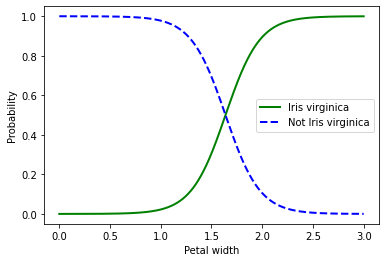

In [48]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = binary_clf.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.xlabel("Petal width")
plt.ylabel("Probability")
plt.legend();

## Model with two features. Compared to basic LogisticRegression with desicion boundaries plots

In [49]:
from sklearn.model_selection import train_test_split
X = iris["data"]  # 
y = iris["target"]  # 

scaler = StdScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [50]:
from sklearn.linear_model import LogisticRegression
sk_lr = LogisticRegression()
sk_lr.fit(X_train, y_train)

softmax_reg = SoftmaxRegressor(verbose=1, n_epochs=1000)
softmax_reg.fit(X_train, y_train)


Epoch: 0, Loss: 0.95977
Epoch: 100, Loss: 0.17828
Epoch: 200, Loss: 0.13011
Epoch: 300, Loss: 0.10931
Epoch: 400, Loss: 0.09752
Epoch: 500, Loss: 0.08982
Epoch: 600, Loss: 0.08434
Epoch: 700, Loss: 0.08021
Epoch: 800, Loss: 0.07697
Epoch: 900, Loss: 0.07434


In [51]:
print(sk_lr.score(X_test, y_test), softmax_reg.score(X_test, y_test))

0.9666666666666667 1.0


In [52]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

from sklearn.linear_model import LogisticRegression
log_regr = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
log_regr.fit(X, y)

my_softmax = SoftmaxRegressor(n_epochs=1000)
my_softmax.fit(X, y)

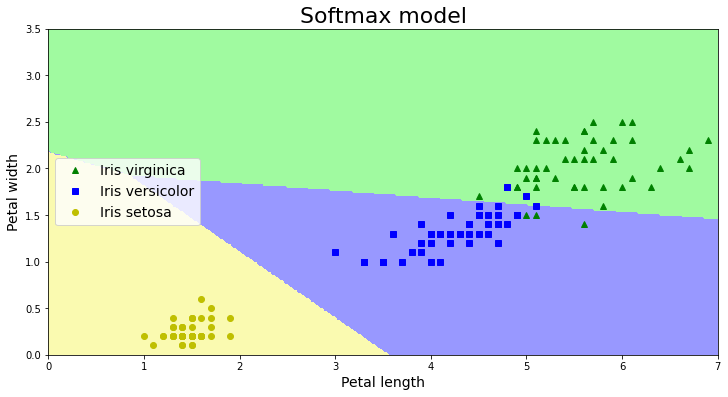

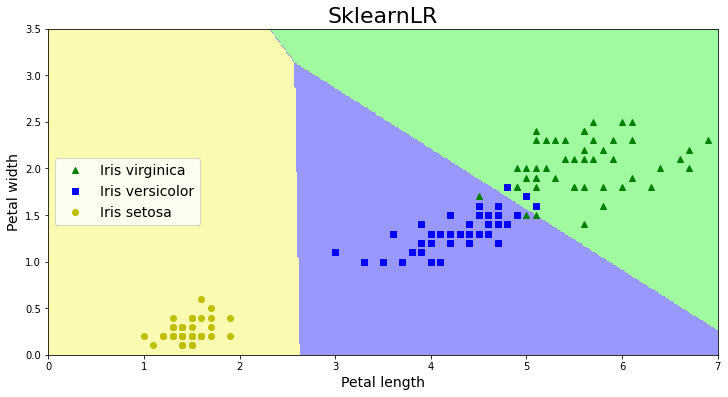

In [53]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

models = {"Softmax model": my_softmax, "SklearnLR": log_regr}

for model_name, model in models.items():
  y_predict = model.predict(X_new)
  zs = y_predict.reshape(x0.shape)
  # Plotting
  plt.figure(figsize=(12, 6))
  plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
  plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
  plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

  from matplotlib.colors import ListedColormap
  custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

  plt.contourf(x0, x1, zs, cmap=custom_cmap)
  plt.xlabel("Petal length", fontsize=14)
  plt.ylabel("Petal width", fontsize=14)
  plt.legend(loc="center left", fontsize=14)
  plt.axis([0, 7, 0, 3.5])
  plt.title(model_name, fontsize=22)
  plt.show()

## Pipeline testing using polynomial features

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

X = iris["data"]
y = iris["target"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
SR_model = Pipeline([("poly", PolynomialFeatures(degree=4)),
                     ("scaler", StandardScaler()),
                     ("model", SoftmaxRegressor(verbose=0))
                     ])
LR_model = Pipeline([("poly", PolynomialFeatures(degree=4)),
                     ("scaler", StandardScaler()),
                     ("model", LogisticRegression())
                     ])

In [ ]:
SR_model.fit(X_train, y_train)
SR_model.score(X_test, y_test)

0.9666666666666667

In [ ]:
LR_model.fit(X_train, y_train)
LR_model.score(X_test, y_test)

0.9666666666666667

# Practical application and text_to_vector transformer
Classification of BBC news articles. The algorithm should correctly classify to which category text corresponds.

Text from https://www.kaggle.com/balatmak/newsgroup20bbcnews

Source data from public data set on BBC news articles: D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006. [PDF] [BibTeX].

http://mlg.ucd.ie/datasets/bbc.html

Cleaned up version exported to https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv

## Imports, data load and splitting

In [ ]:
# Cell with SoftmaxRegressor class must be ran
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Data load
df = pd.read_csv("https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv")
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [ ]:
# Average length of "text" field
print(f"Average length of text field = {df['text'].str.len().mean():.0f} words, amount of exaples = {len(df)}")

Average length of text field = 2263 words, amount of exaples = 2225


In [ ]:
from sklearn.model_selection import train_test_split
X = df["text"]
y = df["category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

I'll use the simple approach of creating dictionary of most common words and transform "text" into one_hot vector, where values correspond to 0 if word isn't present in "text" and 1 if it is. (or bigger than 1 if counting occurrences)

## Creating text to vector transformer class (compatible with Sklearn pipeline)
+ additional imports

In [ ]:
try:
    import google.colab
    !pip install -q -U PyStemmer
except ImportError:
    pass # not running on Colab

     |████████████████████████████████| 563kB 4.2MB/s 


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import csr_matrix, hstack
import re
from collections import Counter
import Stemmer
from sklearn.preprocessing import normalize

stemmer = Stemmer.Stemmer('english')
stemmer.maxCacheSize = 10000

This transoformer takes pd.series with text, creates dictionary of most popular words from whole dataset (of given size) and outputs sparse matrix, that labels words present in the text.

In [ ]:
class TextToVectorTransformer(BaseEstimator, TransformerMixin):
  """
  Takes pd.series with text, creates dictionary of most popular words from whole dataset (of given size)
  and outputs sparse matrix, that labels words present in the text.
  Parameters:
  dict_size: tuple of ints. First number defines how many most popular words to skip
  when forming dictionary, second number - up to what word position include in it.
  Output vector size will be (dict_size[1] - dict_size[0])
  stemming: Bool. If True, apply word stemming.
  count_words: Bool. If True counts word occurrences and performs normalisation
  remove_numbers: Bool. If True, removes numbers.
  remove_punctuation: Bool. If True, removes punctuation.
  """
  def __init__(self, dict_size=(0,1000), stemming=True, count_words=True, remove_numbers=True, remove_punctuation=True):
    # Setting parameters
    self.dict_size = dict_size
    self.stemming = stemming
    self.count_words = count_words
    self.remove_numbers = remove_numbers
    self.remove_punctuation = remove_punctuation
  
  def fit(self, X, y=None):
    self.word_dict = self._form_dictionary(X)
    return self

  def transform(self, X, y=None):
    vectors = np.stack(X.apply(self._text_to_vector))
    if self.count_words:
      vectors = normalize(vectors)
    return csr_matrix(vectors)

  def _form_dictionary(self, X):
    # Make single string from all articles
    all_text = ' '.join(X.tolist())
    all_text = self._preprocess_text(all_text)
    
    word_dict = Counter()
    if self.stemming == True and stemmer is not None:
      stemmed_words = stemmer.stemWords(all_text.split())
      word_dict.update(Counter(stemmed_words))
    else:
      word_dict.update(Counter(all_text.split()))
    
    words_sorted = [word for words, counts in word_dict.most_common(self.dict_size[1]) for word in [words]]
    return words_sorted[self.dict_size[0]:self.dict_size[1]]

  def _preprocess_text(self, text):
    # Transform to lowercase (Optional: remove numbers, remove punctuation)
    text = text.lower()
    if self.remove_numbers:
      text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', '', text)
    if self.remove_punctuation:
      text = re.sub(r'\W+', ' ', text, flags=re.M)
    return text

  def _text_to_vector(self, text):
    vector = np.zeros(len(self.word_dict))

    text = self._preprocess_text(text)
    if self.stemming == True and stemmer is not None:
      words = stemmer.stemWords(text.split())
    else:
      words = text.split()

    for word in words:
      if word in self.word_dict:
        index = self.word_dict.index(word)
        if self.count_words:   # Count words or binary
          vector[index] += 1
        else:
          vector[index] = 1
    return vector


## Getting scores

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [ ]:
preprocess_pipeline = Pipeline([
    ("text_to_vector", TextToVectorTransformer(dict_size=(10,1010), stemming=True, count_words=False))
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)
X_test_transformed = preprocess_pipeline.transform(X_test)

In [ ]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42, max_iter=500)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.964, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] .................................... , score=0.957, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] .................................... , score=0.957, total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s finished


0.9592326139088728

In [ ]:
softmax_clf = SoftmaxRegressor(n_epochs=300, eta=0.1, alpha=0.05)
score = cross_val_score(softmax_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.950, total=   9.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s remaining:    0.0s


[CV] .................................... , score=0.950, total=   9.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.1s remaining:    0.0s


[CV] .................................... , score=0.944, total=   9.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.2s finished


0.947841726618705

So model seems to work fine, though it's not very fast.

Next we'll make a grid search to find proper hyperparameters for model and for text transformer.

I'm not showing here hyperparameters search using RandomSearchCV (it was pretty straightforward and took several hours). 

In [ ]:
full_softmax_pipeline = Pipeline([ 
      ("text_to_vector", TextToVectorTransformer()),
      ("softmax_regr", SoftmaxRegressor())
])

In [ ]:
from sklearn.model_selection import GridSearchCV
grid_preproc = {
    "text_to_vector__dict_size": [(30, 3000), (20, 2000)], 
    "text_to_vector__stemming": [True],
    "text_to_vector__count_words": [True, False],
    "softmax_regr__n_epochs": [300], 
    "softmax_regr__eta": [1, 0.5, 0.3],
    "softmax_regr__alpha": [0.005, 0]

}

gs_sftm = GridSearchCV(full_softmax_pipeline, grid_preproc, cv=5, verbose=2)
# Commenting out fitting, because it's slow
#gs_sftm.fit(X_train, y_train);

In [ ]:
# This params were found to be best by grid search in the previous cell
best_params = {'softmax_regr__alpha': 0.005,
 'softmax_regr__eta': 0.3,
 'softmax_regr__n_epochs': 300,
 'text_to_vector__count_words': False,
 'text_to_vector__dict_size': (30, 3000),
 'text_to_vector__stemming': True}

In [ ]:
cvres = gs_sftm.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.9358759957562353 {'softmax_regr__alpha': 0.005, 'softmax_regr__eta': 1, 'softmax_regr__n_epochs': 300, 'text_to_vector__count_words': True, 'text_to_vector__dict_size': (30, 3000), 'text_to_vector__stemming': True}
0.9274783765801731 {'softmax_regr__alpha': 0.005, 'softmax_regr__eta': 1, 'softmax_regr__n_epochs': 300, 'text_to_vector__count_words': True, 'text_to_vector__dict_size': (20, 2000), 'text_to_vector__stemming': True}
0.9628346909784036 {'softmax_regr__alpha': 0.005, 'softmax_regr__eta': 1, 'softmax_regr__n_epochs': 300, 'text_to_vector__count_words': False, 'text_to_vector__dict_size': (30, 3000), 'text_to_vector__stemming': True}
0.963429896962831 {'softmax_regr__alpha': 0.005, 'softmax_regr__eta': 1, 'softmax_regr__n_epochs': 300, 'text_to_vector__count_words': False, 'text_to_vector__dict_size': (20, 2000), 'text_to_vector__stemming': True}
0.9442610274945604 {'softmax_regr__alpha': 0.005, 'softmax_regr__eta': 0.5, 'softmax_regr__n_epochs': 300, 'text_to_vector__count_w

In [ ]:
gs_sftm.score(X_test, y_test)

0.9712746858168761

Of course we can get better results by doing more thorough hyperparameter tuning.

# Final notes

In this notebook I won't dive deeper in error analysis. There is a lot of ways to improve this model, but it won't be very practical (since this is mostly a study project)

Main goal was to build a model that can perform multilabel classification on different datasets reasonably well.

It's pretty hard to achieve close to 100% score on BBC news dataset using this text preprocessing method. In this task it was obviously a weak link.

**Notes**
+ Default hyperparameters can be not very reasonable for other cases (beware underfitting)

+ Model is very sensitive to feature scaling. Big feature values will throw overflow errors.